# To do:

- Use the Atlantic Causal Inference Conference Simulations
- Add in c-for-benefit analysis
- 
- data starvation experiment?

In [135]:
library(Matching)
library(plyr)
library(tidyverse)
library(stringr)
library(magrittr)
library(caret)
library(rlang)
source("src/simulation_scenarios.R")
source("src/hte_caret.R")
source("src/hte_cv.R")
source("src/eval_hte_cv.R")
# detach("package:plyr", unload=TRUE)

In [136]:
model = list(method="xgbTree",
             tune_grid=expand.grid(nrounds = seq(1,501,10), max_depth = c(2), eta = 0.2))
scenario = 2
training_percent = 0.2
n_folds = 5
rep = 1

data_stuff = setup_data(scenario, training_percent, n_folds)
estimate_stuff = data_stuff %$% get_estimates(data, model, cv_index, test_index, aux_data)
error_stuff = estimate_stuff %$% get_errors(cv_estimates, test_estimates)

In [134]:
derp = data_stuff$data %>% 
    filter(set=="training") %>%
    cross_estimate_hte(model$method, model$tune_grid, data_stuff$cv_index) 

## plot

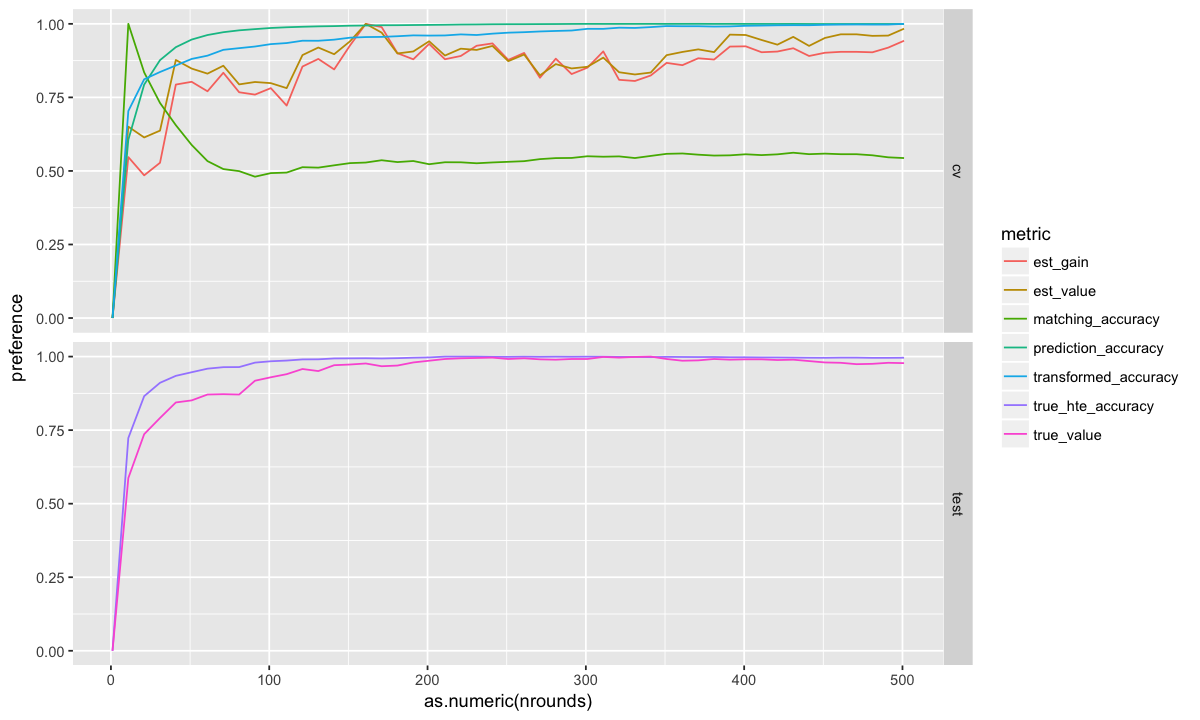

In [137]:
options(repr.plot.width=10, repr.plot.height=6)

cv_plot = error_stuff$cv_accuracy %>%
    separate(model, model %$% c(method, names(tune_grid)), sep="~") %>%
    rename(metric=selection_method) %>%
    group_by(metric) %>%
    mutate(preference = (accuracy - min(accuracy, na.rm=T))/(max(accuracy, na.rm=T)-min(accuracy, na.rm=T))) %>%
    mutate(evaluation = "cv")

# ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
#     geom_line(aes(color=metric)) 

test_plot = error_stuff$test_accuracy %>% 
    separate(model, model %$% c(method, names(tune_grid)), sep="~") %>%
    mutate(true_hte_accuracy = -true_hte_error) %>%
    select(-true_hte_error) %>%
    gather(metric, accuracy, true_hte_accuracy, true_value) %>%
    group_by(metric) %>%
    mutate(preference = (accuracy - min(accuracy))/(max(accuracy)-min(accuracy))) %>%
    mutate(evaluation = "test")

# # ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
# #     geom_line(aes(color=metric), size=3) 

cv_plot %>% bind_rows(test_plot) %>%
ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
    geom_line(aes(color=metric)) + 
    facet_grid(evaluation~.)

In [138]:
error_stuff$true_selection_accuracy %>% arrange(-true_hte_error) %>% data.frame

,model,selection_method,true_hte_error,true_value
1,xgbTree~11~2~0.2,matching_accuracy,1.344743,0.7233463
2,xgbTree~161~2~0.2,est_gain,0.4756162,0.7993178
3,xgbTree~161~2~0.2,est_value,0.4756162,0.7993178
4,xgbTree~501~2~0.2,transformed_accuracy,0.4701224,0.7995466
5,xgbTree~371~2~0.2,prediction_accuracy,0.4626744,0.8013772


In [117]:
loop_test = function(scenario, n_folds, training_percent, rep, model) {

    errors = setup_data(scenario, training_percent, n_folds) %$%
        get_estimates(data, model, cv_index, test_index, aux_data) %$% 
        get_errors(cv_estimates, test_estimates) 
    true_selection_accuracy = errors$true_selection_accuracy %>%
        mutate(scenario=scenario, n_folds=n_folds, training_percent=training_percent, rep=rep)
    
    return(true_selection_accuracy)
}

In [70]:
# methods = list("xgbTree",
#                "derp")
# tune_grids = list(expand.grid(nrounds = seq(1,501,50), max_depth = c(3), eta = 0.2),
#                   expand.grid(lambda=0:20))
# models = list(methods, tune_grids) %>%
#     pmap(~list(method=.x, tune_grid=.y))

model = list(method="xgbTree",
             tune_grid=expand.grid(nrounds = seq(1,501,10), max_depth = c(3), eta = 0.2))
simulation_params = list(scenario=c(1:16),
                         n_folds=5,
                         training_percent=0.5,
                         rep = 1:10) %>% cross

In [71]:
results = simulation_params %>% 
    map(~loop_test(.$scenario, .$n_folds, .$training_percent, .$rep, model)) %>%
    bind_rows()

In [72]:
processed_results = results %>%
    group_by(scenario, rep) %>% 
    mutate(rel_value = true_value/max(true_value, rm.na=T),
#        rel_value_opt = true_deficiency/optimal_deficiency,
       rel_increased_error = true_hte_error/min(true_hte_error, rm.na=T))

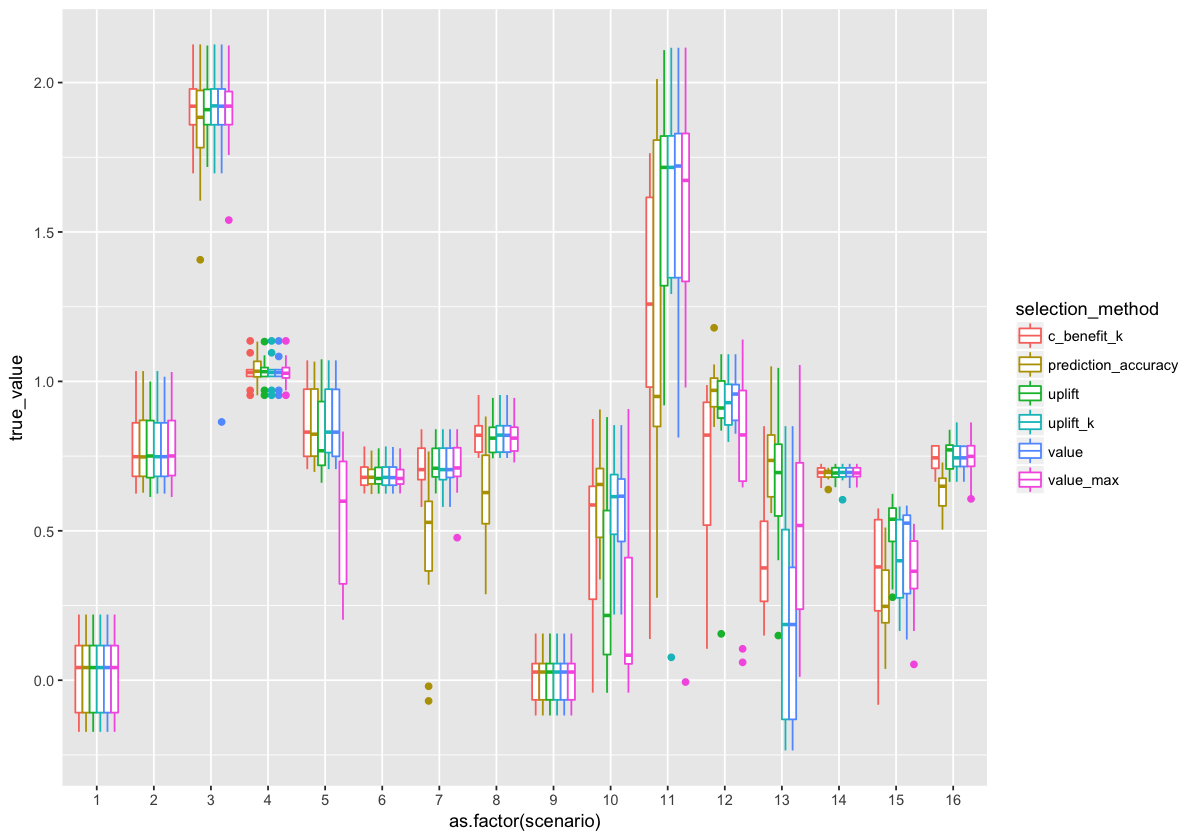

In [73]:
options(repr.plot.width=10, repr.plot.height=7)
processed_results %>%
ggplot(aes(x=as.factor(scenario), y=true_value, color=selection_method)) +
    geom_boxplot()

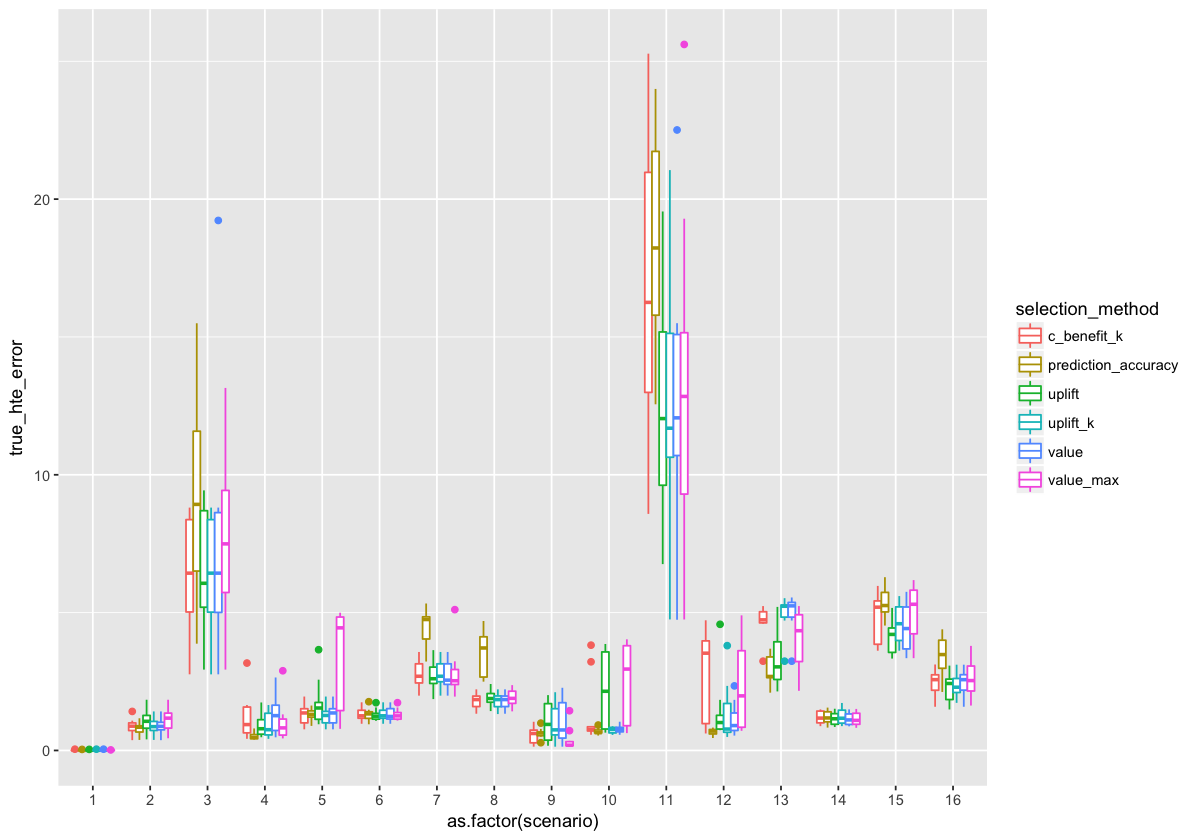

In [74]:
options(repr.plot.width=10, repr.plot.height=7)
results %>%
ggplot(aes(x=as.factor(scenario), y=true_hte_error, color=selection_method)) +
    geom_boxplot()